In [41]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 760.5/760.5 kB 13.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 48.0 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.9/110.9 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.0/275.0 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.2/169.2 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.6/154.6 kB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 11.1 MB/s eta 0:00:00
  Created wheel 

In [42]:
# https://github.com/GuansongPang/ADRepository-Anomaly-detection-datasets/tree/main
import pandas as pd
import seaborn as sns
# import sweetviz as svz
import matplotlib.pyplot as plt
# import prince
from sklearn.decomposition import PCA
from statsmodels.tsa.seasonal import STL 
from statsmodels.tsa.stattools import pacf,acf
import numpy as np
import re

In [43]:
plt.rcParams["figure.figsize"]=(20,5)
plt.rcParams["figure.dpi"]=100

In [44]:
df = pd.read_csv("/kaggle/input/monthly-sun-spots/monthly-sunspots.csv",parse_dates=["Month"])

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2820 entries, 0 to 2819
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Month     2820 non-null   datetime64[ns]
 1   Sunspots  2820 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 44.2 KB


# STL Resiudal

In [46]:
df["ogSunspots"] = df["Sunspots"].values
#df["Sunspots"] = np.log10(df["Sunspots"]-df["Sunspots"].min()+1)

<Axes: ylabel='Sunspots'>

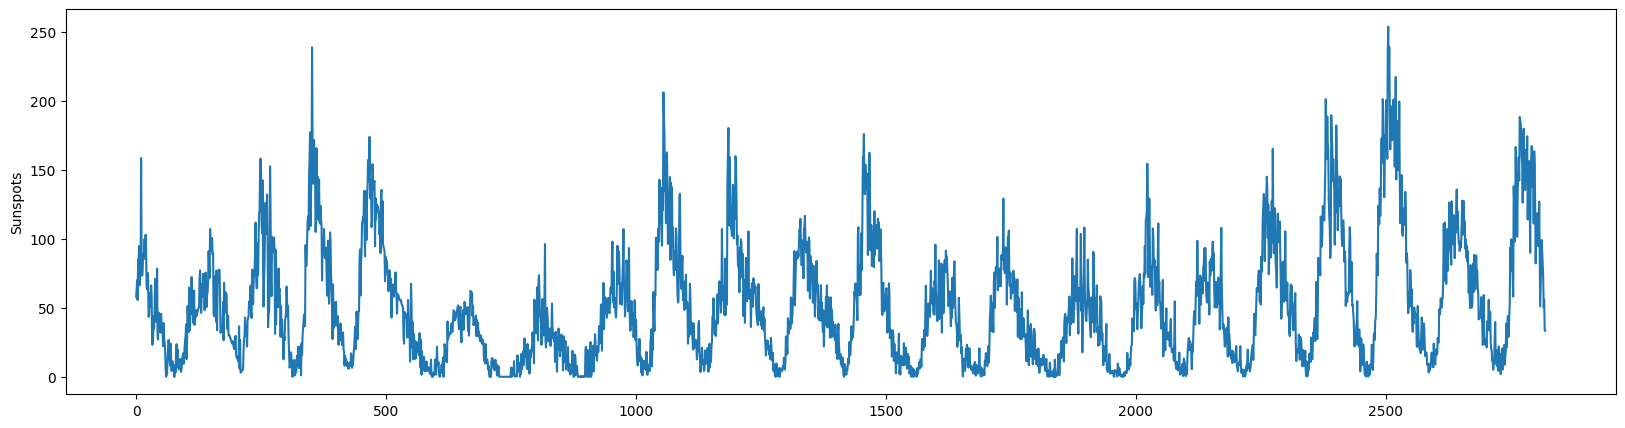

In [47]:
sns.lineplot(data=df["Sunspots"])

<Axes: xlabel='index', ylabel='0'>

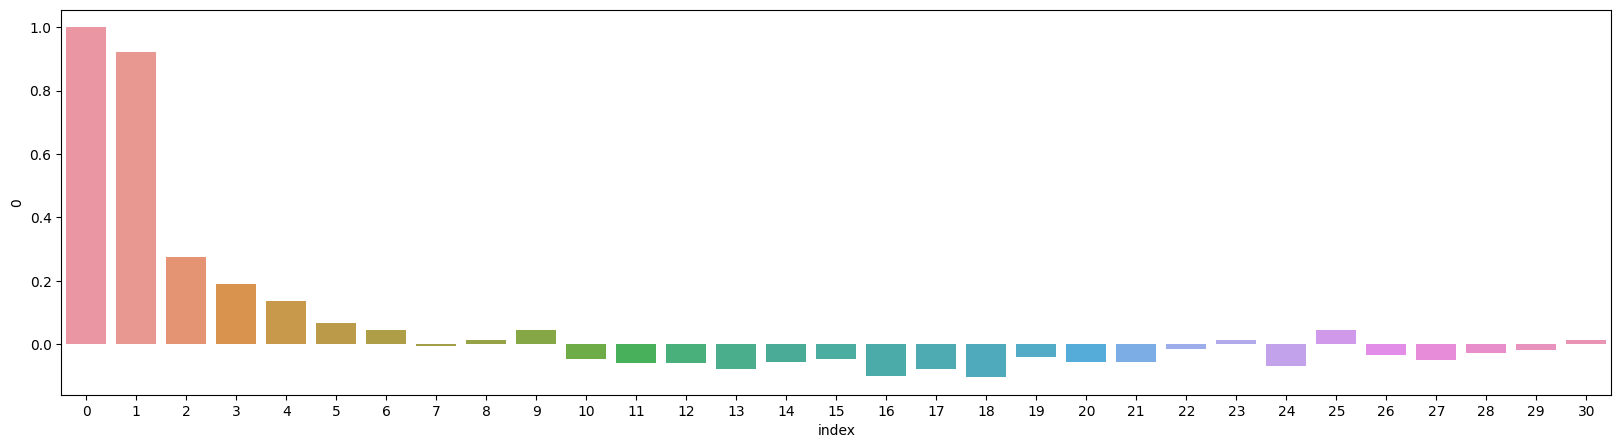

In [48]:
sns.barplot(data=pd.Series(pacf(df["Sunspots"],30)).to_frame().reset_index(),y=0,x="index")

<Axes: xlabel='index', ylabel='0'>

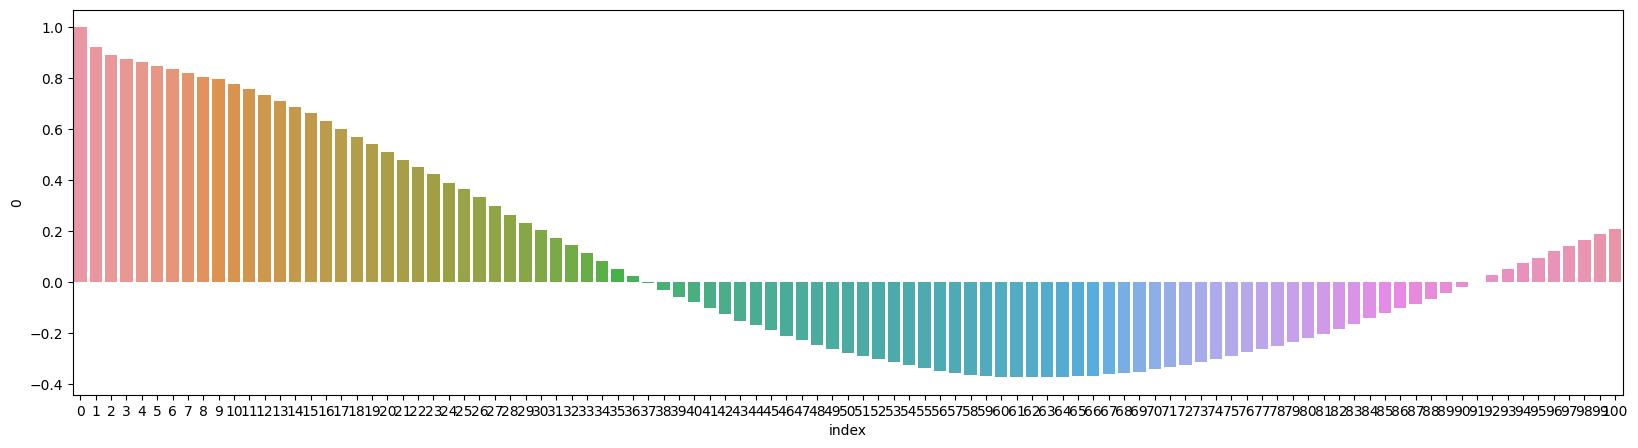

In [49]:
sns.barplot(data=pd.Series(acf(df["Sunspots"],nlags=100)).to_frame().reset_index(),y=0,x="index")

In [50]:
stl=STL(df["Sunspots"],5)
stl_results=stl.fit()

DONE


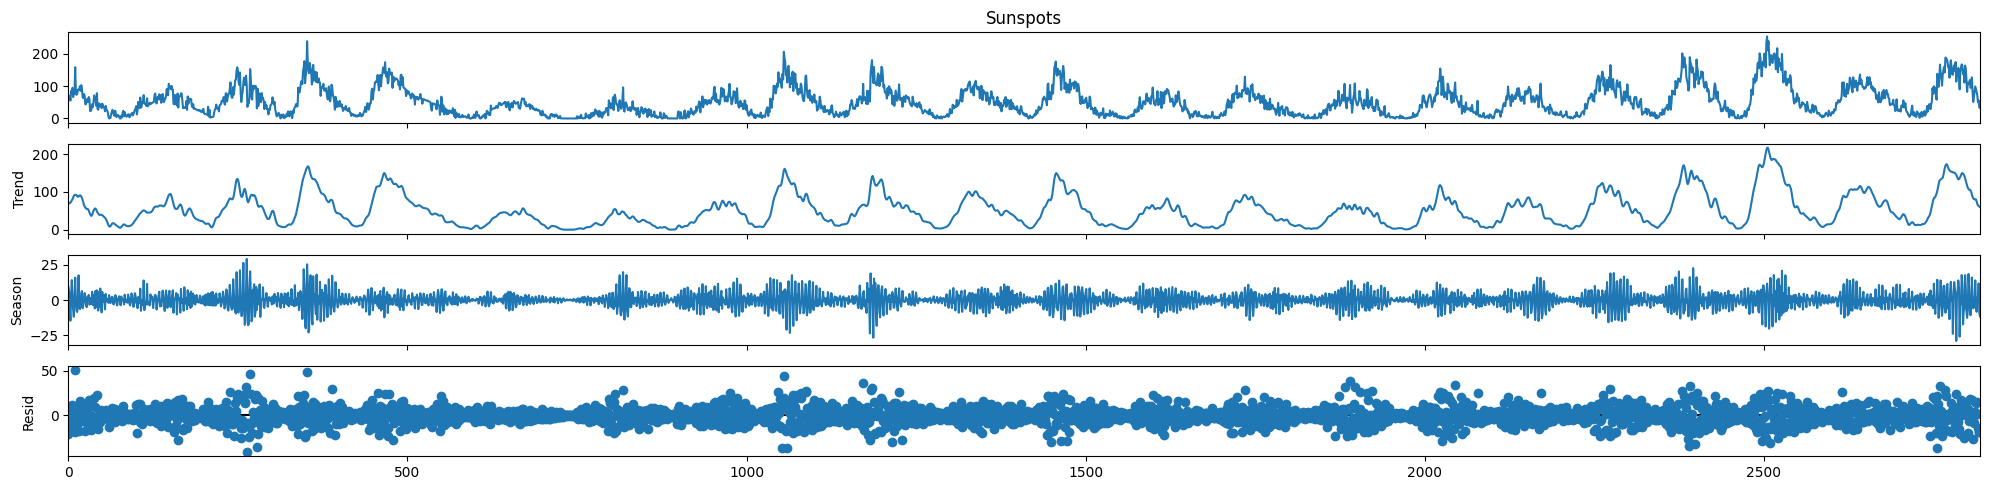

In [51]:
stl_results.plot()
print("DONE")

[-18.962568007954225, 21.289428972276312]


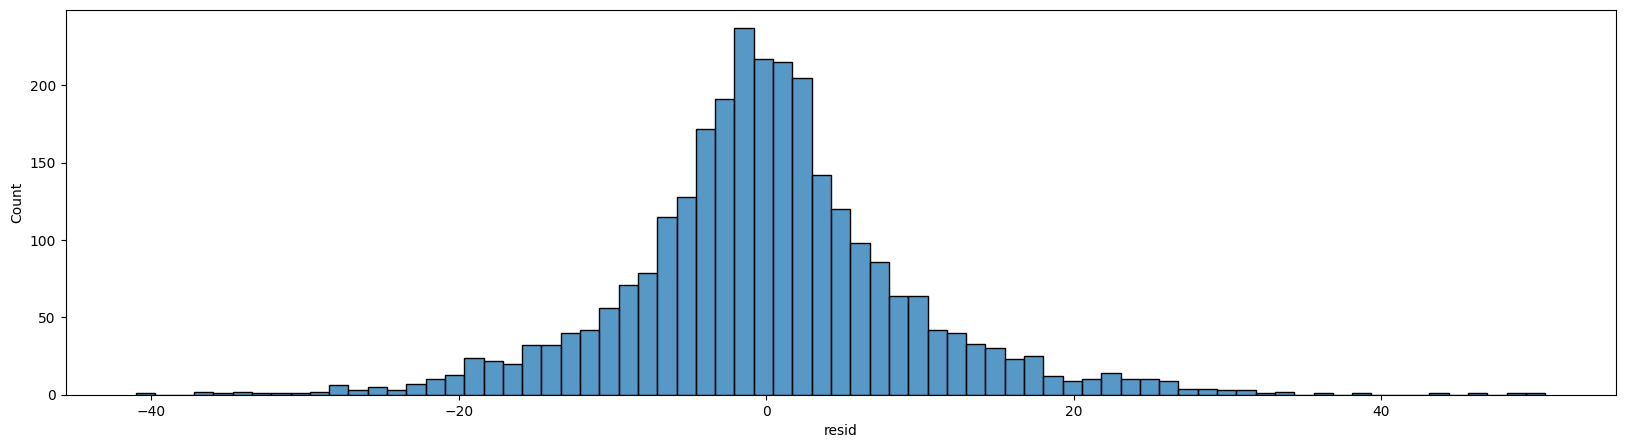

In [52]:
sns.histplot(data=stl_results.resid)
print([stl_results.resid.quantile(0.025),stl_results.resid.quantile(0.975)])

<Axes: >

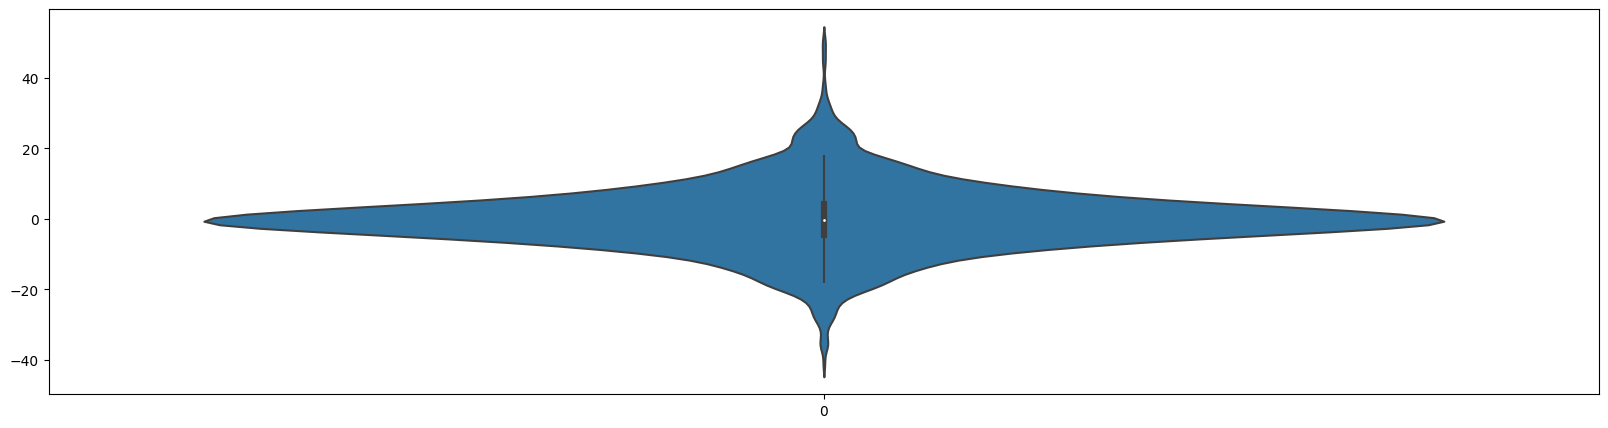

In [53]:
sns.violinplot(data=stl_results.resid)

(0.06948920682484994, 0.0009999999999998899)

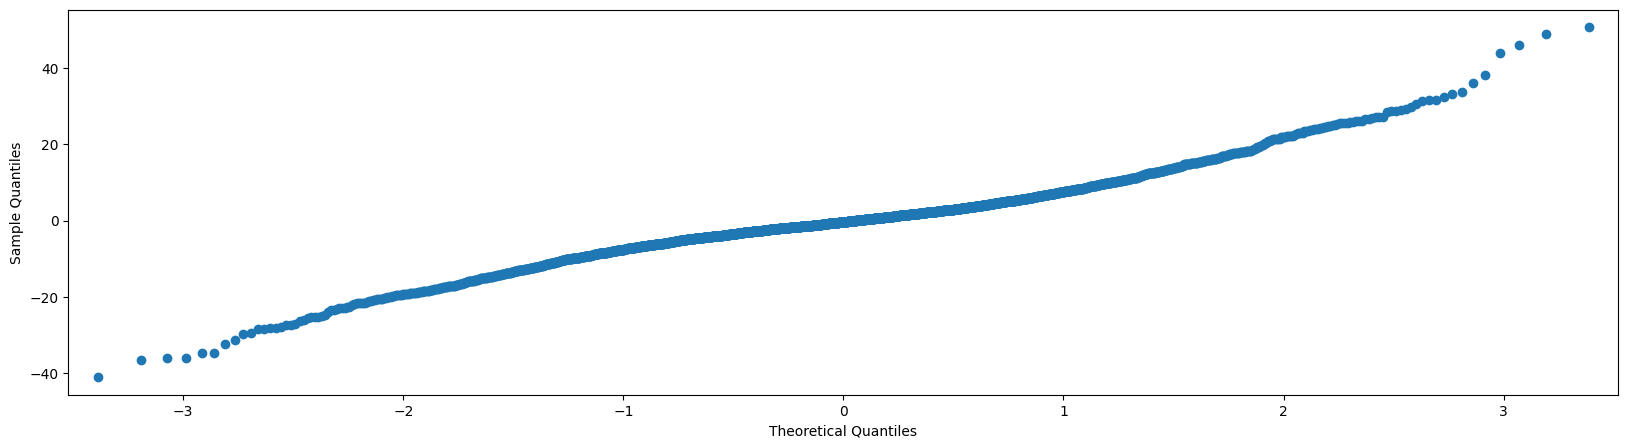

In [54]:
from statsmodels.stats.diagnostic import kstest_normal
from statsmodels.graphics.gofplots import qqplot
qqplot(stl_results.resid)
kstest_normal(stl_results.resid)


In [55]:
anomalies_index=pd.concat([stl_results.resid[stl_results.resid < stl_results.resid.quantile(0.05)],stl_results.resid[stl_results.resid > stl_results.resid.quantile(0.95)]]).index
df["anomaly"]="no"
df.loc[anomalies_index,"anomaly"]="yes"

<Axes: xlabel='Month', ylabel='ogSunspots'>

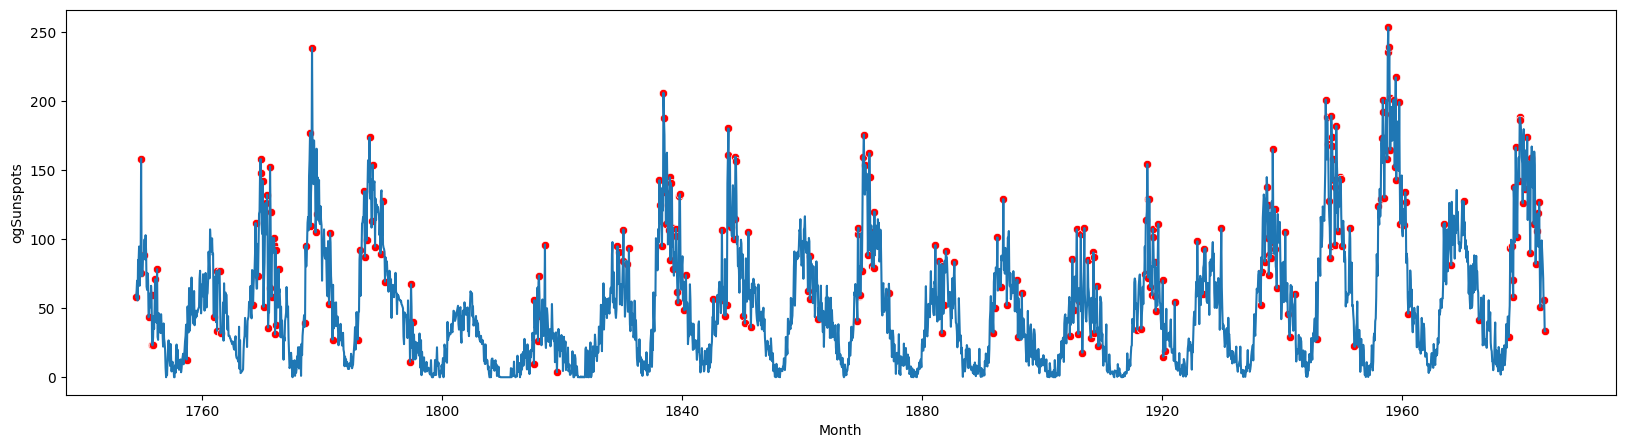

In [56]:
sns.lineplot(data=df,x="Month",y="ogSunspots")
sns.scatterplot(data=df[df["anomaly"]=="yes"],x="Month",y="ogSunspots",color="red")

# Forecasting using FFT ( can be used for realtime instead of batch detection ) 

In [77]:
from darts.models.forecasting.fft import FFT
from darts.timeseries import TimeSeries
fft=FFT(100,trend="poly",trend_poly_degree=1)
ddf = TimeSeries.from_dataframe(df.set_index("Month")[["ogSunspots"]])
fft.fit(ddf["ogSunspots"])

FFT(nr_freqs_to_keep=100, required_matches=None, trend=poly, trend_poly_degree=1)

In [78]:
predicted=np.array(fft.predicted_values)+df["ogSunspots"].mean()


<Axes: xlabel='Month'>

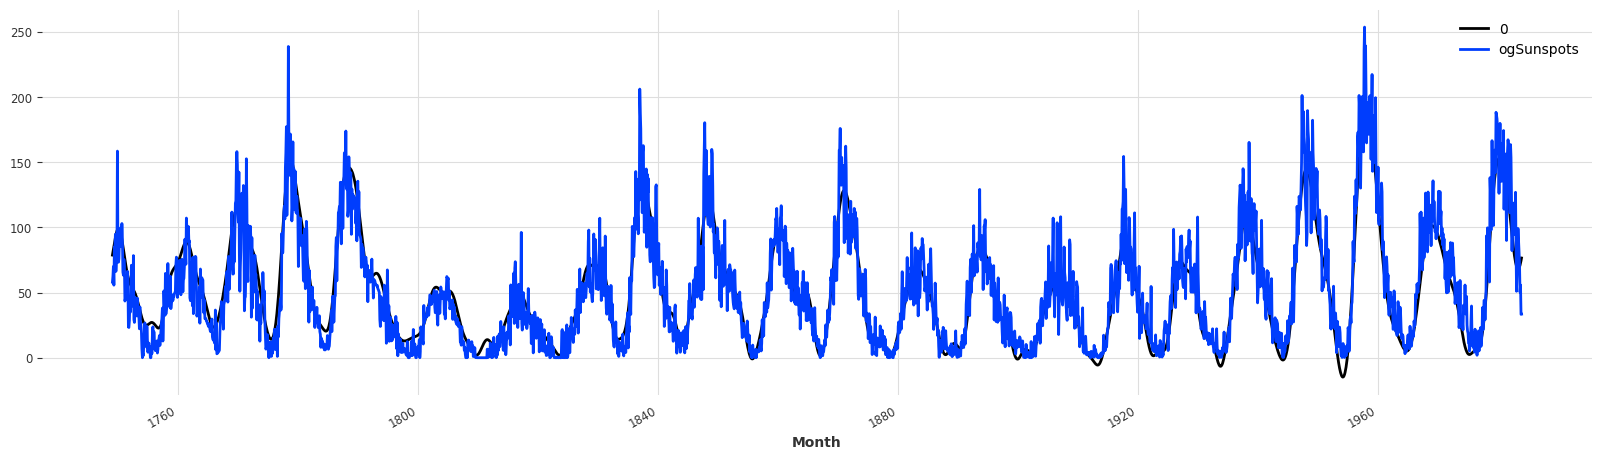

In [79]:
predicted_train = TimeSeries.from_series(pd.Series(predicted,index=df["Month"]))
predicted_train.plot()
ddf.plot()

<Axes: xlabel='ogSunspots', ylabel='Count'>

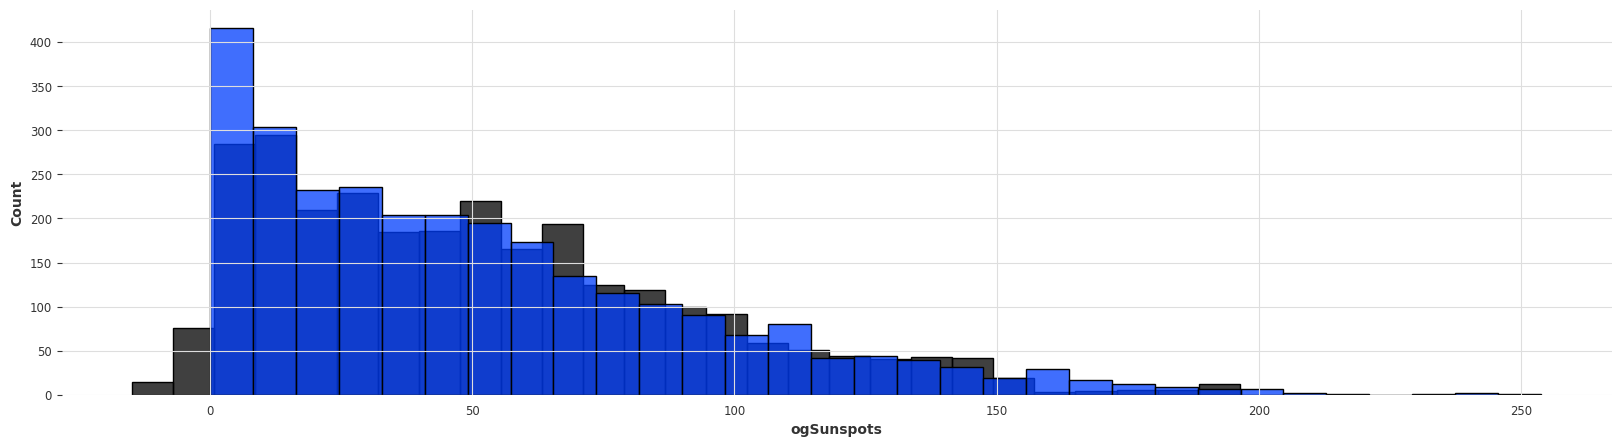

In [80]:
sns.histplot(data=predicted)
sns.histplot(data=df["ogSunspots"])

In [82]:
residual = df["ogSunspots"]-predicted
residual

0      -20.773285
1      -18.532317
2      -13.545432
3      -30.253507
4       -3.297875
          ...    
2815     2.078365
2816   -20.700711
2817   -16.790184
2818   -41.148038
2819   -43.126544
Name: ogSunspots, Length: 2820, dtype: float64

<Axes: xlabel='ogSunspots', ylabel='Count'>

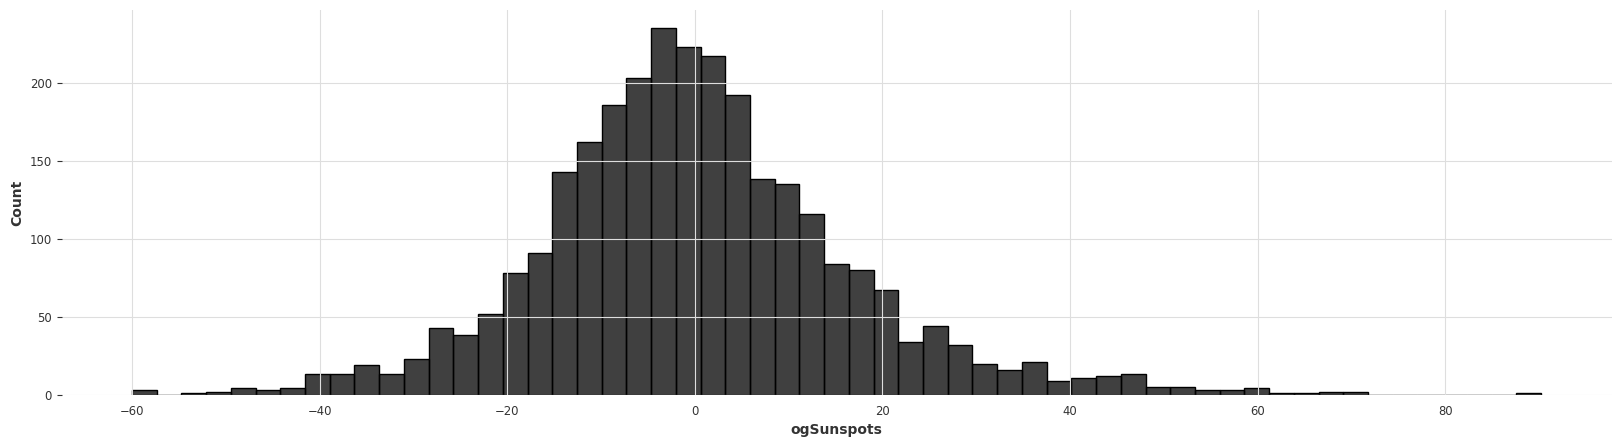

In [83]:
sns.histplot(residual)

(0.058644123542926696, 0.0009999999999998899)

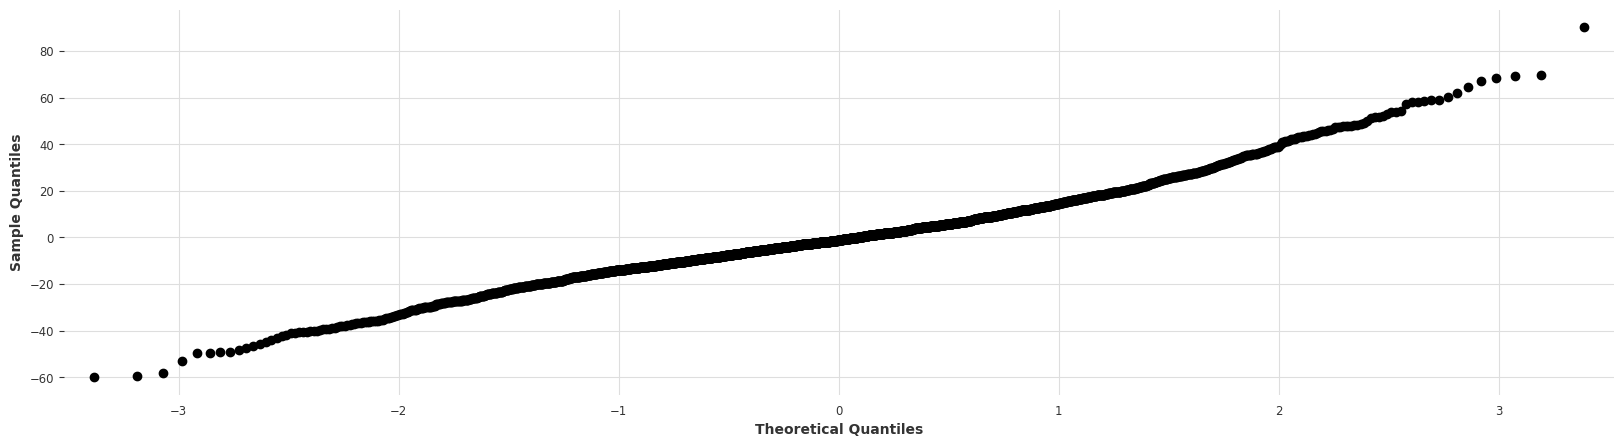

In [84]:
from statsmodels.stats.diagnostic import kstest_normal
from statsmodels.graphics.gofplots import qqplot
qqplot(residual)
kstest_normal(residual)


In [85]:
anomalies_index=pd.concat([residual[stl_results.resid < stl_results.resid.quantile(0.025)],residual[stl_results.resid > stl_results.resid.quantile(0.975)]]).index
df["anomaly2"] = 0

In [86]:
df.loc[anomalies_index,"anomaly2"]=1

<Axes: xlabel='Month', ylabel='ogSunspots'>

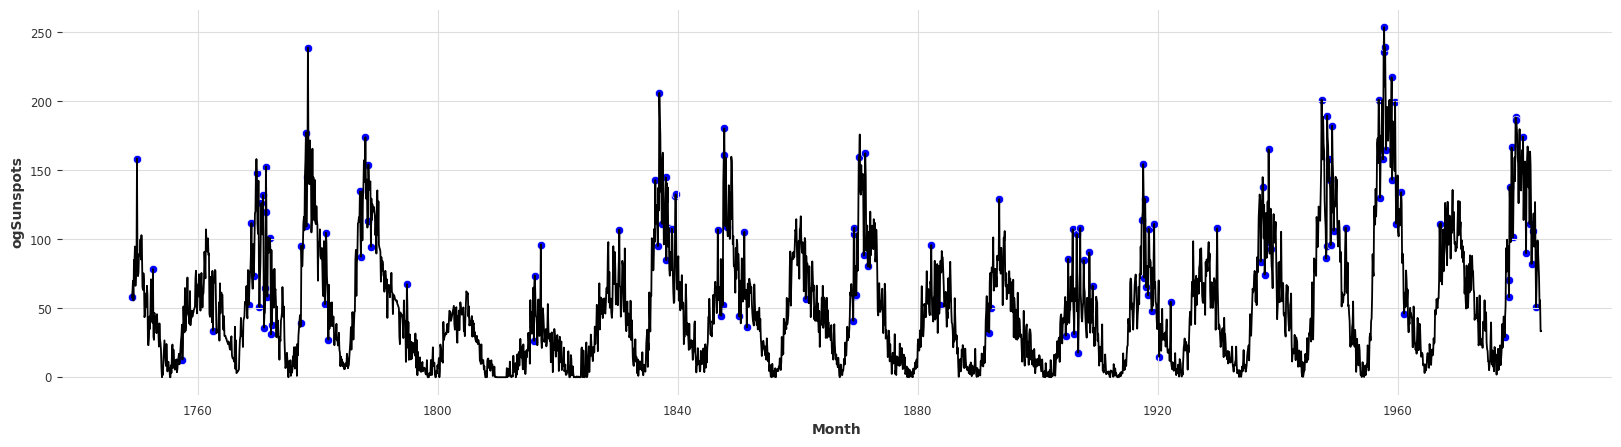

In [87]:
sns.lineplot(data=df,x="Month",y="ogSunspots")
sns.scatterplot(data=df.query("anomaly2 == 1"),x="Month",y="ogSunspots",color="blue")
#sns.scatterplot(data=df.query("anomaly == 'yes'"),x="Month",y="ogSunspots",color="red")

Pyodb Scorer with darts

In [88]:
org=TimeSeries.from_series(pd.Series(predicted,index=df["Month"]))
prd=TimeSeries.from_series(pd.Series(df["ogSunspots"].values,index=df["Month"]))

<Axes: ylabel='Count'>

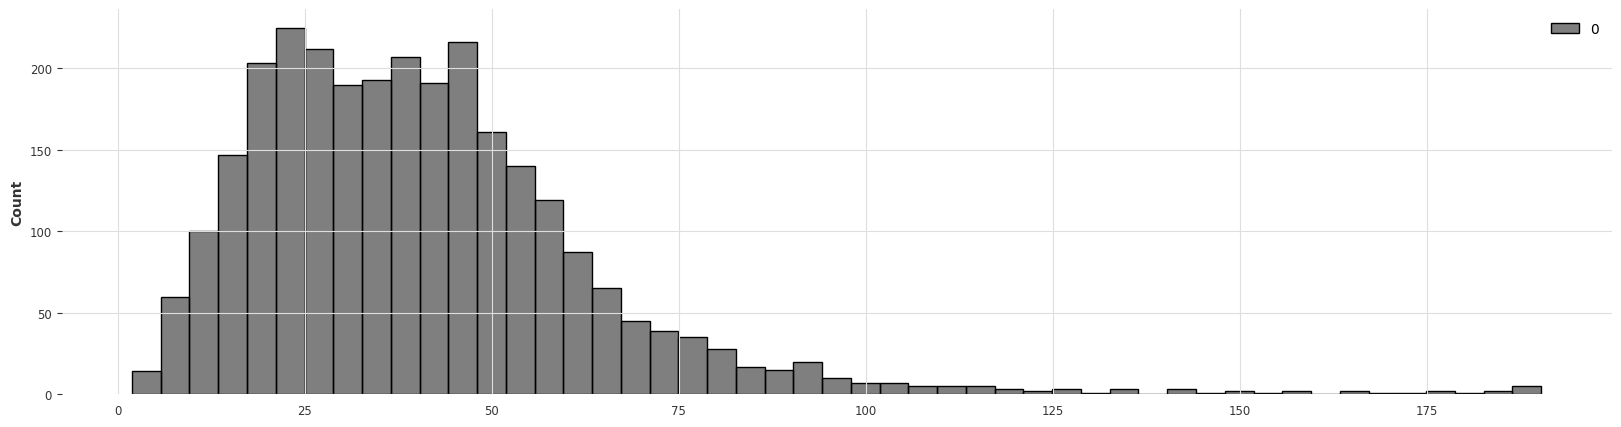

In [89]:
from darts.ad.scorers.kmeans_scorer import KMeansScorer
df_scorer = KMeansScorer(18)
df_scorer.fit(org)
sns.histplot(df_scorer.score(org).values())

In [90]:
pd.Series(df_scorer.score(org).values().ravel()).quantile(0.975)

95.22415822633488

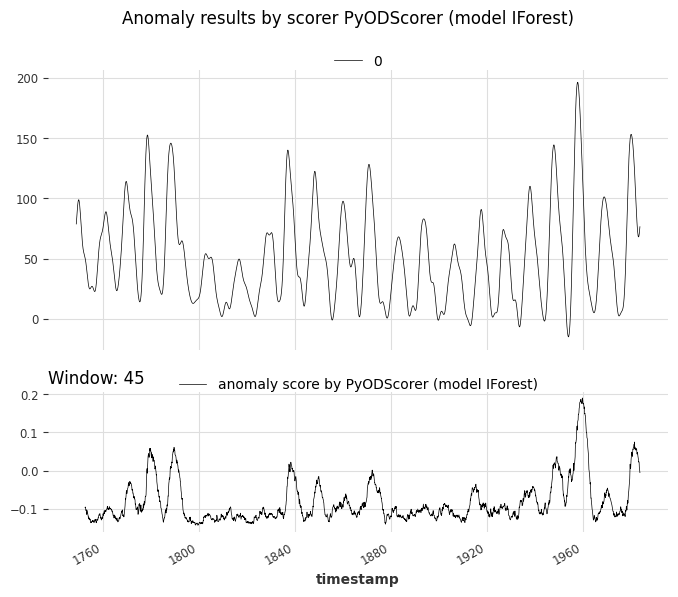

In [100]:
from darts.ad.scorers.pyod_scorer import PyODScorer
from pyod.models.iforest import IForest
py = PyODScorer(IForest(),45)
py.fit(org)
res = pd.Series(py.score(org).values().ravel())
py.show_anomalies(org)


In [101]:
from darts.ad.anomaly_model import ForecastingAnomalyModel
from darts.models.forecasting.exponential_smoothing import ExponentialSmoothing
from darts.ad.scorers import difference_scorer
exp_md = ExponentialSmoothing()
exp_md.fit(org)


ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=None, random_state=0)

<Axes: xlabel='Month'>

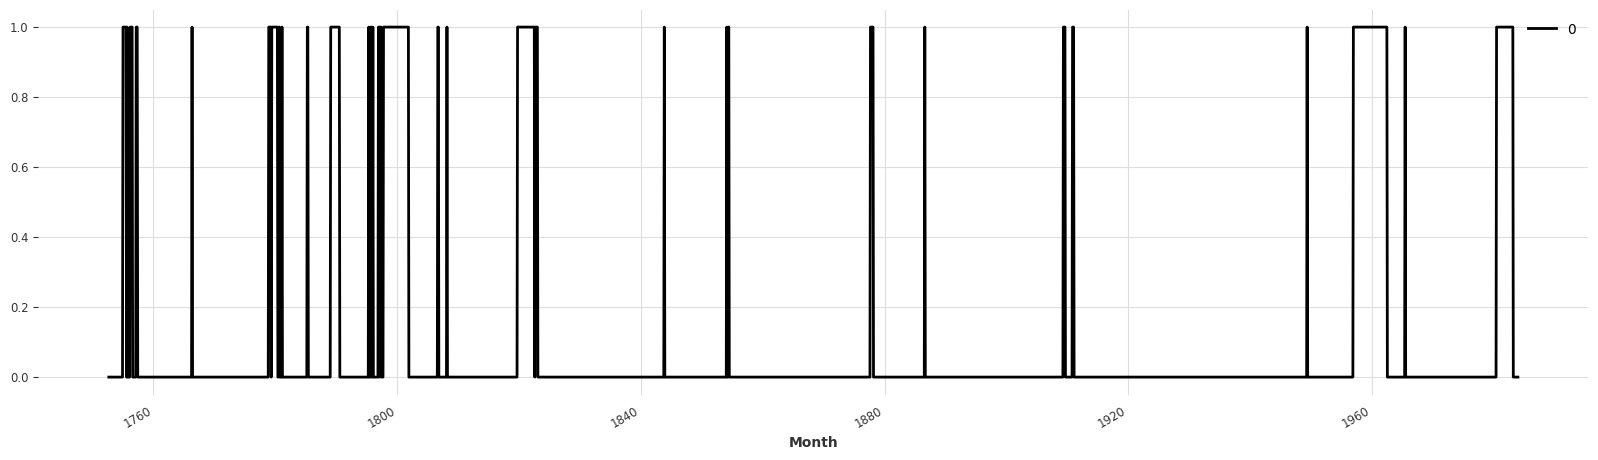

In [102]:
from darts.ad.detectors import QuantileDetector
qd = QuantileDetector(0.05,0.95)
qd.fit(py.score(org))
qd.detect(py.score(org)).plot()